We analyze data from small crosslinking simulations to evaluate the algorithm's effectiveness. We focus on verifying crosslink locations and calculating network properties like pore size distribution. We find that the actual number of crosslinks frequently exceeds the desired count, particularly when using a large target mesh width and increasing the number of chains. We also investigate the correlation between mesh width and median pore size.

In [9]:
import sys
import importlib

sys.path.append("../")

In [10]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import common
import analysis
import analysis.network

importlib.reload(common)
importlib.reload(analysis)
importlib.reload(analysis.network)

<module 'analysis.network' from '/Users/r/Documents/work/icp/microgel/code/src/notebooks/../analysis/network.py'>

In [11]:
root_dir = Path("../../data/raw/21102024_crosslinking_fixed")
gel_dirs = list(map(common.GelDir.from_inner, root_dir.rglob("current_checkpoint.txt")))
gel_dirs

[GelDir(path=PosixPath('../../data/raw/21102024_crosslinking_fixed/old_crosslinking_chains=40/ff=none_meshw=6.0')),
 GelDir(path=PosixPath('../../data/raw/21102024_crosslinking_fixed/old_crosslinking_chains=40/ff=none_meshw=1.5')),
 GelDir(path=PosixPath('../../data/raw/21102024_crosslinking_fixed/old_crosslinking_chains=40/ff=none_meshw=3.0')),
 GelDir(path=PosixPath('../../data/raw/21102024_crosslinking_fixed/old_crosslinking_chains=70_meshw=6.0/chainlength=40')),
 GelDir(path=PosixPath('../../data/raw/21102024_crosslinking_fixed/old_crosslinking_chains=70_meshw=6.0/chainlength=30')),
 GelDir(path=PosixPath('../../data/raw/21102024_crosslinking_fixed/old_crosslinking_chains=70_meshw=6.0/chainlength=20')),
 GelDir(path=PosixPath('../../data/raw/21102024_crosslinking_fixed/old_crosslinking_chains=70_meshw=6.0/chainlength=60')),
 GelDir(path=PosixPath('../../data/raw/21102024_crosslinking_fixed/old_crosslinking_chains=70_meshw=6.0/chainlength=50')),
 GelDir(path=PosixPath('../../data/ra

In [12]:
def find_and_check_pairs(arr, p):
    """
    Prints pairs with repeated elements and checks for multiples of p.

    Args:
        arr: A NumPy array of shape (N, 2) containing integer pairs.
        p: An integer to check for multiplicity.
    """
    N = arr.shape[0]
    if N == 0:  # Handle empty array
        return

    # Efficiently find repeated elements using sets and dictionaries
    all_elements = arr.flatten()
    counts = {}
    repeated_elements = set()

    for element in all_elements:
        if element in counts:
            counts[element] += 1
            repeated_elements.add(element)
        else:
            counts[element] = 1

    # Iterate through the pairs and check for repeated elements and multiples of p
    total = 0
    for pair in arr:
        for element in pair:
            if counts[element] < 2:
                continue
            mask = (
                (arr[:, 0] == pair[0])
                | (arr[:, 1] == pair[0])
                | (arr[:, 0] == pair[1])
                | (arr[:, 1] == pair[1])
            )
            print(
                f"[{counts[pair[0]]}x |{pair[0]:>5}| ({str((pair[0] % p == 0) or ((pair[0]+1) % p == 0)):5}, {p}),"
                f" {counts[pair[1]]}x |{pair[1]:>5}| ({str((pair[1] % p == 0) or ((pair[1]+1) % p == 0)):5}, {p})]"
                f" {arr[mask].tolist()}"
            )
            total += 1
            break
    if total > 0:
        print(f"Total: {total}")
        print(arr.T)
        print("-" * 100)
        print()


# # Example usage:
# arr = np.array([[1, 2], [3, 4], [1, 5], [6, 2], [7, 8], [3, 9]])
# p = 3

# find_and_check_pairs(arr, p)


# arr2 = np.array(
#     [[1, 2], [3, 2], [5, 6]]
# )  # Example with all pairs having a repeated element.
# p2 = 2
# find_and_check_pairs(arr2, p2)


# arr3 = np.array([])  # Example with empty array
# p3 = 3

# find_and_check_pairs(arr3, p3)  # Should not print anything

In [16]:
records = []
for i, gel_dir in enumerate(gel_dirs):
    if gel_dir.n_crosslinks < 1:
        print(gel_dir.path.relative_to(root_dir), "failed")
        continue
    if gel_dir.config.n_chains != 70 or gel_dir.config.desired_mesh_width != 6.0:
        # print("Wrong experiment run")
        continue
    pore_analyzer = analysis.network.PoreAnalyzer.from_gel_dir(gel_dir.path)
    records.append(
        dict(
            chain_length=gel_dir.config.chain_length,
            n_crosslinks=gel_dir.n_crosslinks,
            desired_n_crosslinks=gel_dir.config.n_crosslinks,
            n_pores=len(pore_analyzer.pores),
            pore_size_mean=np.mean(pore_analyzer.beads_per_pore),
            pore_size_median=np.median(pore_analyzer.beads_per_pore),
            beads_per_pore=pore_analyzer.beads_per_pore,
        )
    )

    find_and_check_pairs(gel_dir.crosslinks_numpy, gel_dir.config.chain_length)

df_70s = pd.DataFrame.from_records(records).sort_values(
    by="chain_length", ignore_index=True
)
df_70s

old_crosslinking_chains=240/ff=none_meshw=3.0 failed


,chain_length,n_crosslinks,desired_n_crosslinks,n_pores,pore_size_mean,pore_size_median,beads_per_pore
0,20,84,73,15,41.066667,15.0,"[7, 15, 3, 151, 3, 3, 44, 43, 53, 108, 3, 91, ..."
1,30,110,110,41,47.951220,5.0,"[4, 4, 3, 3, 3, 3, 96, 4, 5, 182, 18, 5, 3, 3,..."
2,40,147,147,78,52.371795,6.5,"[15, 17, 3, 3, 8, 26, 46, 68, 58, 3, 3, 3, 3, ..."
3,50,184,184,115,69.365217,6.0,"[3, 3, 3, 5, 135, 205, 3, 86, 3, 4, 3, 3, 3, 6..."
4,60,221,221,152,96.125000,7.0,"[3, 3, 14, 4, 4, 3, 3, 5, 3, 4, 3, 8, 3, 4, 13..."


In [27]:
records = []
for i, gel_dir in enumerate(gel_dirs):
    if gel_dir.n_crosslinks < 1:
        print(gel_dir.path.relative_to(root_dir), "failed")
        continue
    if gel_dir.config.chain_length != 20:
        continue
    pore_analyzer = analysis.network.PoreAnalyzer.from_gel_dir(gel_dir.path)
    records.append(
        dict(
            n_chains=gel_dir.config.n_chains,
            meshw=gel_dir.config.desired_mesh_width,
            n_crosslinks=gel_dir.n_crosslinks,
            desired_n_crosslinks=gel_dir.config.n_crosslinks,
            n_pores=len(pore_analyzer.pores),
            pore_size_mean=np.mean(pore_analyzer.beads_per_pore),
            pore_size_median=np.median(pore_analyzer.beads_per_pore),
            beads_per_pore=pore_analyzer.beads_per_pore,
        )
    )
import pandas as pd

df = pd.DataFrame.from_records(records).sort_values(by=["n_chains", "meshw"], ignore_index=True)
df = df.astype({"meshw": "category"})
df

old_crosslinking_chains=240/ff=none_meshw=3.0 failed


,n_chains,meshw,n_crosslinks,desired_n_crosslinks,n_pores,pore_size_mean,pore_size_median,beads_per_pore
0,40,1.5,160,160,121,38.214876,7.0,"[3, 16, 3, 5, 3, 3, 3, 16, 5, 4, 3, 3, 14, 3, ..."
1,40,3.0,80,80,41,39.804878,4.0,"[3, 4, 3, 3, 9, 4, 4, 4, 14, 46, 5, 52, 10, 11..."
2,40,6.0,42,42,3,14.666667,3.0,"[3, 38, 3]"
3,70,6.0,84,73,15,41.066667,15.0,"[7, 15, 3, 151, 3, 3, 44, 43, 53, 108, 3, 91, ..."
4,130,1.5,520,520,391,109.196931,7.0,"[9, 3, 18, 3, 18, 3, 3, 38, 14, 3, 3, 4, 5, 6,..."
5,130,3.0,260,260,131,67.801527,6.0,"[3, 6, 21, 4, 3, 9, 8, 7, 5, 4, 3, 3, 10, 19, ..."
6,130,6.0,162,136,33,18.363636,4.0,"[4, 3, 4, 11, 3, 4, 22, 3, 63, 11, 3, 31, 3, 4..."
7,190,1.5,760,760,571,83.022767,5.0,"[4, 3, 3, 8, 4, 3, 3, 3, 8, 9, 3, 15, 3, 3, 3,..."
8,190,3.0,380,380,191,122.460733,5.0,"[3, 4, 3, 3, 3, 3, 3, 77, 3, 3, 18, 3, 191, 3,..."
9,190,6.0,224,200,35,76.000000,9.0,"[3, 18, 4, 58, 75, 3, 3, 4, 4, 201, 3, 4, 256,..."


## Mittlere Länge der kürzesten Schlaufe

In [19]:
df["smallest_pore_size"] = [min(x) for x in df["beads_per_pore"]]
df.groupby("meshw").agg("mean")["smallest_pore_size"]

/var/folders/9k/pz7sq18n26sdjld2rt5h1dr80000gn/T/ipykernel_13195/2484063399.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("meshw").agg("mean")["smallest_pore_size"]


meshw
1.5    3.0
3.0    3.0
6.0    3.0
Name: smallest_pore_size, dtype: float64

## Mittlere Anzahl der Kettenglieder zwischen zwei Cross-Links (aka. beads per pore)
Ist aber ziemlich nichtssagend, daher besser Median

In [28]:
df[["n_chains", "meshw", "pore_size_median"]]

,n_chains,meshw,pore_size_median
0,40,1.5,7.0
1,40,3.0,4.0
2,40,6.0,3.0
3,70,6.0,15.0
4,130,1.5,7.0
5,130,3.0,6.0
6,130,6.0,4.0
7,190,1.5,5.0
8,190,3.0,5.0
9,190,6.0,9.0


Was ich beim testen beobachtet habe:
- desired_n_crosslinks wird bei wenig chains unabhängig von der meshweite nicht durchbrochen. das liegt daran, dass es relativ einfach ist alle chains zu einem kluster zu verknüpfen, weil es eben so wenig sind.

Deshalb habe ich für beide meschweiten jeweils experimente gestartet, bei denen ich beads_per_chain konstant halte und n_chains vergrößere. dadurch wollte ich sehen wie stark die Durchbrechnung von desired_n_crosslinks zunimmt, bei steigender n_chains.

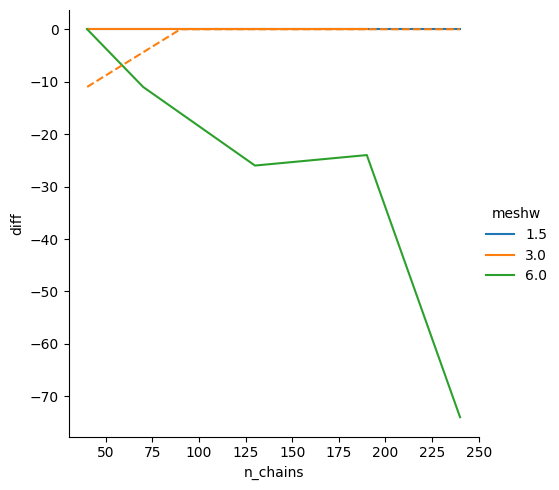

In [21]:
import seaborn as sns

sns.relplot(
    df.assign(diff=df["desired_n_crosslinks"] - df["n_crosslinks"]),
    kind="line",
    x="n_chains",
    y="diff",
    hue="meshw",
)
plt.plot(
    (df_70s["chain_length"] - df_70s["chain_length"].min()) * 5 + df["n_chains"].min(),
    df_70s["desired_n_crosslinks"] - df_70s["n_crosslinks"],
    "--",
    color="C1",
)
plt.show()

Analyse:
- Für kleine meshweite (ergo viele crosslinks) gibt es kein Problem und das einzelne kluster ist geformt bevor die maximale anzahl crosslinks verbraucht ist.
- Für größe meshweite (ergo wenig crosslinks) ist das nicht der Fall. Die Anzahl an mehr benötigten crosslinks steigt proportional zur Anzahl Ketten an.

Lösungsvorschläge:
- Klar ist: Bei konstanter Kettenanzahl, aber steigender Kettenlänge, sollte es einfacher sein, die Grenze nicht zu durchbrechen. Ich starte zur Sicherheit aber mal ein paar Runs mit großer meshw um es zu verifizieren.
- Jetzt könnte man schauen ob es einen sweetspot

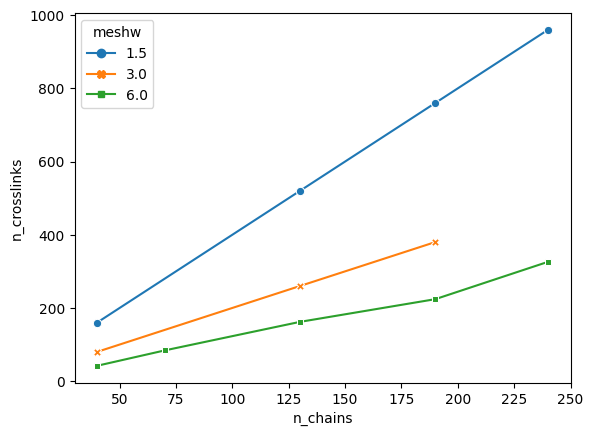

In [22]:
import seaborn as sns

sns.lineplot(
    df,
    x="n_chains",
    y="n_crosslinks",
    hue="meshw",
    style="meshw",
    markers=True,
    dashes=False,
)
plt.plot(
    df[df["meshw"] == 2.0]["n_chains"],
    df[df["meshw"] == 2.0]["desired_n_crosslinks"],
    "--",
    color="C0",
)
plt.plot(
    df[df["meshw"] == 5.0]["n_chains"],
    df[df["meshw"] == 5.0]["desired_n_crosslinks"],
    "--",
    color="C1",
)
plt.show()

ich hätte gerne eine klare positive korrelation von meshw zur median pore size

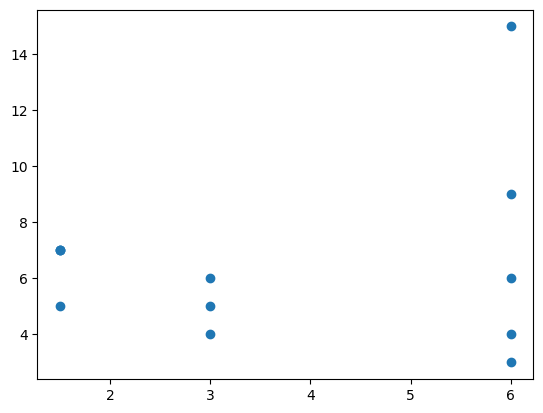

In [23]:
plt.scatter(df["meshw"], df["pore_size_median"])
plt.show()

auch wenn man den outlier bei meshw=2 und median pore size ca 20 raus nimmt, ist die korrelation nicht wirklich gut.

In [24]:
df_exploded = df.explode("beads_per_pore").reset_index(drop=True)

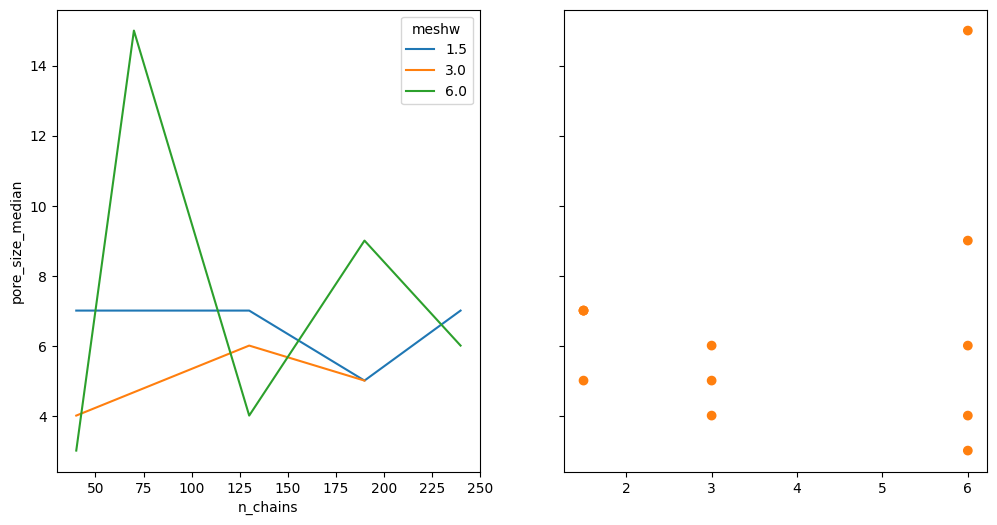

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
sns.lineplot(df, x="n_chains", y="pore_size_median", hue="meshw", ax=ax1)
ax2.scatter(
    df["meshw"], df["pore_size_median"], c=np.where(df["meshw"] == 2.0, "C0", "C1")
)
plt.show()

For this I would expect/want that the smaller meshw also has the smaller median pore size. That is its line is always below the other.

And indeed, this is almost true. But also not really statistically significant.

But why do I see it here but not in the korrelation plot? The korrelation plot is basically a projection of this plot onto the y axis. (left side of y for small meshw and right side for large)

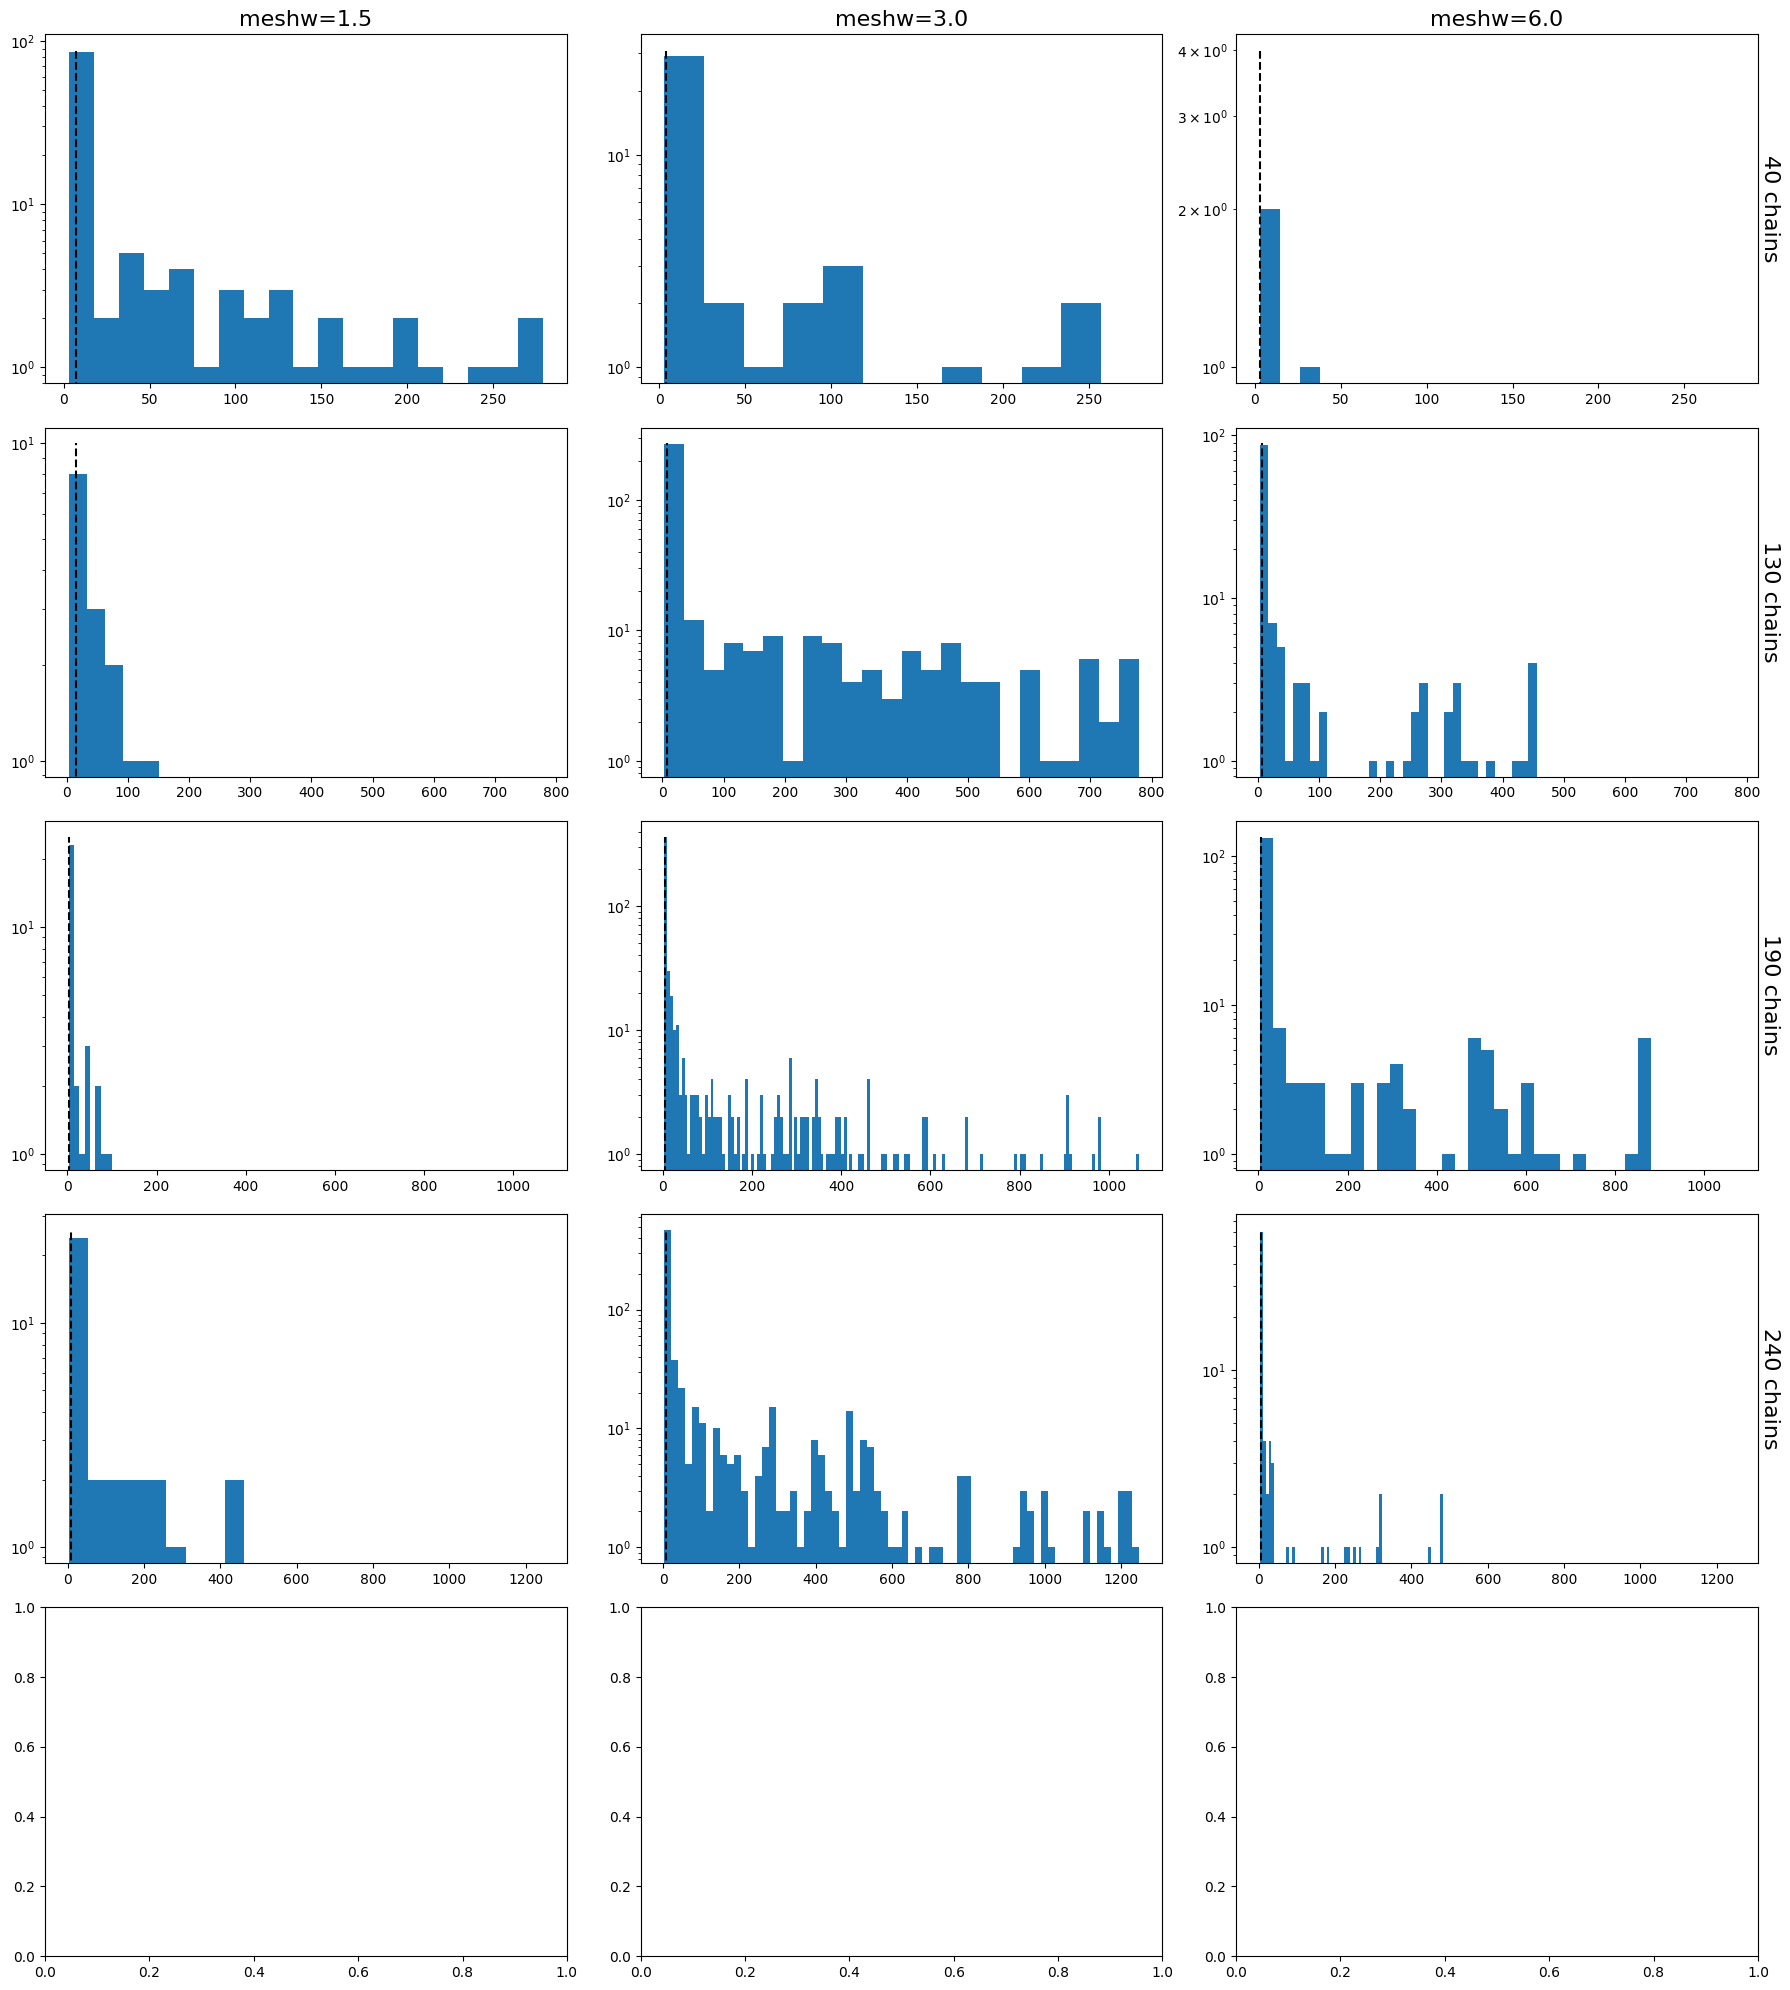

In [30]:
import matplotlib.transforms as transforms

TEXT_SIZE = 16

ncols = 3
nrows = len(df["n_chains"].unique())
fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(6 * ncols, 4 * nrows), sharex="row", sharey=False
)
for i, ((n_chains, meshw), sub_df) in enumerate(
    df_exploded.groupby(["n_chains", "meshw"])
):
    row = i // ncols
    col = i % ncols
    ax: plt.Axes = axs[row, col]
    if row == 0:
        ax.set_title(f"{meshw=}", size=TEXT_SIZE)
    if col == ncols - 1:
        offset = transforms.ScaledTranslation(
            0.02, 0, fig.dpi_scale_trans
        )  # Adjust offset as needed
        transform = ax.transAxes + offset  # Combine with axes transform
        ax.text(
            1.0,
            0.5,
            f"{n_chains} chains",
            rotation=-90,
            va="center",
            transform=transform,
            size=TEXT_SIZE,
        )

    dens, bins, _ = ax.hist(sub_df["beads_per_pore"], bins="auto")
    ax.vlines(
        [np.median(sub_df["beads_per_pore"])],
        0,
        np.max(dens) + 2,
        colors="black",
        linestyles="--",
    )
    ax.set_yscale("log")
plt.tight_layout()
plt.show()